In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import GloVe
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle
from utils import TextEmotionDataset

In [10]:
import os
import pickle

# Define the base path relative to the notebook's location
base_path = os.getcwd() 

# Paths to your files
tokenizer_path = os.path.join(base_path, 'tokenizer_pytorch.pkl')
processed_data_path = os.path.join(base_path, 'processed_data_pytorch.pkl')
label_encoder_path = os.path.join(base_path, 'label_encoder_pytorch.pkl')

# Load the tokenizer to get the vocabulary size
with open(tokenizer_path, 'rb') as file:
    tokenizer = pickle.load(file)

# Load the processed data
with open(processed_data_path, 'rb') as file:
    X_train_pad, X_val_pad, X_test_pad, y_train, y_val, y_test, max_seq_length = pickle.load(file)

# Load the label encoder
with open(label_encoder_path, 'rb') as file:
    label_encoder = pickle.load(file)

# Create datasets and dataloaders for training, validation, and testing
train_dataset = TextEmotionDataset(X_train_pad, y_train)
val_dataset = TextEmotionDataset(X_val_pad, y_val)  # Assuming you have a validation dataset
test_dataset = TextEmotionDataset(X_test_pad, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)  # Assuming the same batch size as train_loader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [11]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, n_filters, filter_sizes, drop_prob=0.5):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, n_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_size)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # add channel (1, L, D)
        x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]  # [(N, Co, W), ...]*len(Ks)
        x = [torch.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logit = self.fc(x)
        return logit

# Parameters
vocab_size = len(tokenizer.word_index) + 1
output_size = len(label_encoder.classes_)
embedding_dim = 100
n_filters = 100
filter_sizes = [3, 4, 5]

# Instantiate the model, loss, and optimizer
model1 = CNNModel(vocab_size, output_size, embedding_dim, n_filters, filter_sizes)

In [12]:
# GloVe embeddings
vocab_size = len(tokenizer.word_index) + 1
glove = GloVe(name='6B', dim=100)
embedding_matrix = torch.zeros((vocab_size, glove.dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = glove.vectors[glove.stoi[word]] if word in glove.stoi else torch.randn(glove.dim)
    embedding_matrix[index] = embedding_vector


class BiLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, pretrained_embeddings, drop_prob=0.5):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        # Apply dropout only if n_layers > 1
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob if n_layers > 1 else 0, 
                            batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim * 2, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1]
        out = self.dropout(lstm_out)
        out = self.fc(out)
        soft_out = self.softmax(out)
        return soft_out

# Instantiate the model with the embedding matrix
model2 = BiLSTM(
    vocab_size, 
    len(label_encoder.classes_), 
    100,  # embedding dimension
    256,  # hidden dimension
    2,    # number of LSTM layers
    embedding_matrix  # pretrained GloVe embeddings
)

In [13]:

# Attention module
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.main = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )

    def forward(self, lstm_output):
        attn_weights = self.main(lstm_output)
        attn_weights = torch.softmax(attn_weights.squeeze(2), dim=1)
        return attn_weights

# EnhancedRNNModel
class AttBiLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, pretrained_embeddings, drop_prob=0.5):
        super(AttBiLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob if n_layers > 1 else 0, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(drop_prob)
        self.attention = Attention(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        attn_weights = self.attention(lstm_out)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1), lstm_out).squeeze(1)
        out = self.dropout(attn_applied)
        out = self.fc(out)
        soft_out = self.softmax(out)
        return soft_out

model3 = AttBiLSTM(vocab_size, len(label_encoder.classes_), 100, 256, 2, embedding_matrix)

In [14]:
# import and compare models

model1.load_state_dict(torch.load('/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/saved_models/cnn_emo.pth'))
model2.load_state_dict(torch.load('/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/saved_models/bi_lstm_emo.pth'))
model3.load_state_dict(torch.load('/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/saved_models/att_bi_lstm_emo.pth'))

<All keys matched successfully>

In [15]:
# Evaluate the models on the test set

def evaluate(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in test_loader:
            text, target = batch
            output = model(text)
            y_true.extend(target.tolist())
            y_pred.extend(torch.argmax(output, 1).tolist())
    return y_true, y_pred

# Evaluate the models
y_true1, y_pred1 = evaluate(model1, test_loader)
y_true2, y_pred2 = evaluate(model2, test_loader)
y_true3, y_pred3 = evaluate(model3, test_loader)

# Print classification reports
print('CNN')
print(classification_report(y_true1, y_pred1, target_names=label_encoder.classes_))
print('BiLSTM')
print(classification_report(y_true2, y_pred2, target_names=label_encoder.classes_))
print('AttBiLSTM')
print(classification_report(y_true3, y_pred3, target_names=label_encoder.classes_))

/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/emo2019/utils.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(self.X[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.long)


CNN
              precision    recall  f1-score   support

       angry       0.84      0.86      0.85       298
       happy       0.90      0.80      0.85       284
         sad       0.77      0.84      0.80       250

    accuracy                           0.83       832
   macro avg       0.84      0.83      0.83       832
weighted avg       0.84      0.83      0.83       832

BiLSTM
              precision    recall  f1-score   support

       angry       0.87      0.83      0.85       298
       happy       0.88      0.82      0.85       284
         sad       0.77      0.87      0.81       250

    accuracy                           0.84       832
   macro avg       0.84      0.84      0.84       832
weighted avg       0.84      0.84      0.84       832

AttBiLSTM
              precision    recall  f1-score   support

       angry       0.88      0.92      0.90       298
       happy       0.94      0.88      0.91       284
         sad       0.85      0.86      0.85       250


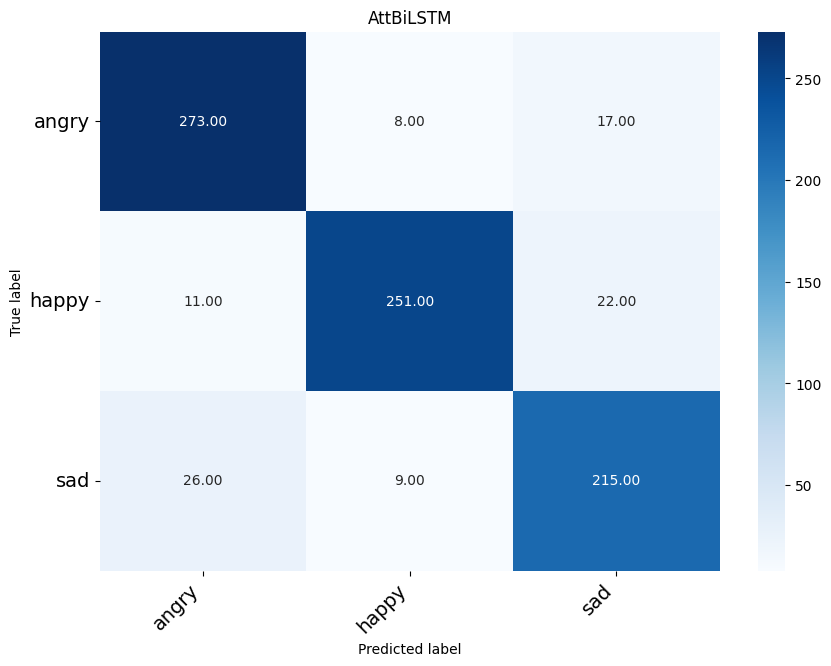

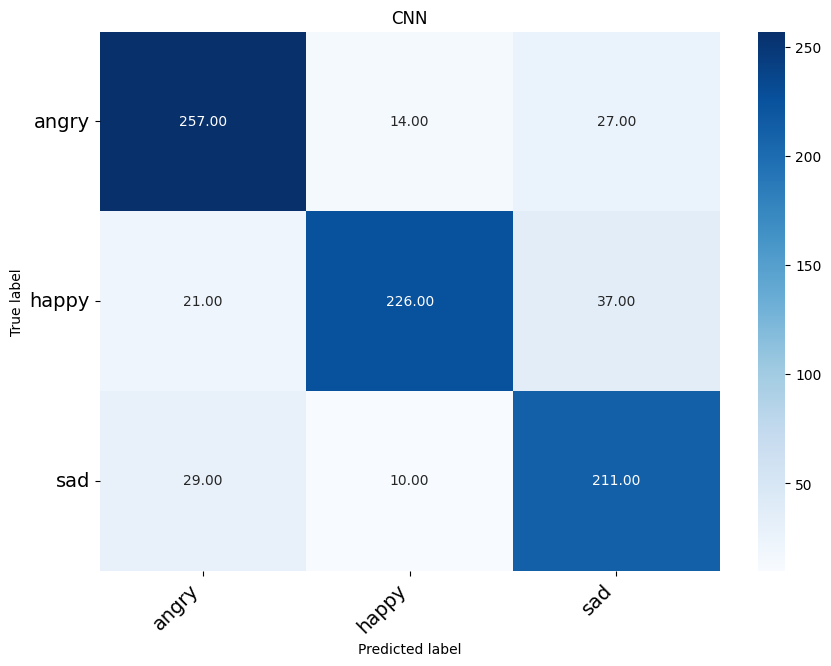

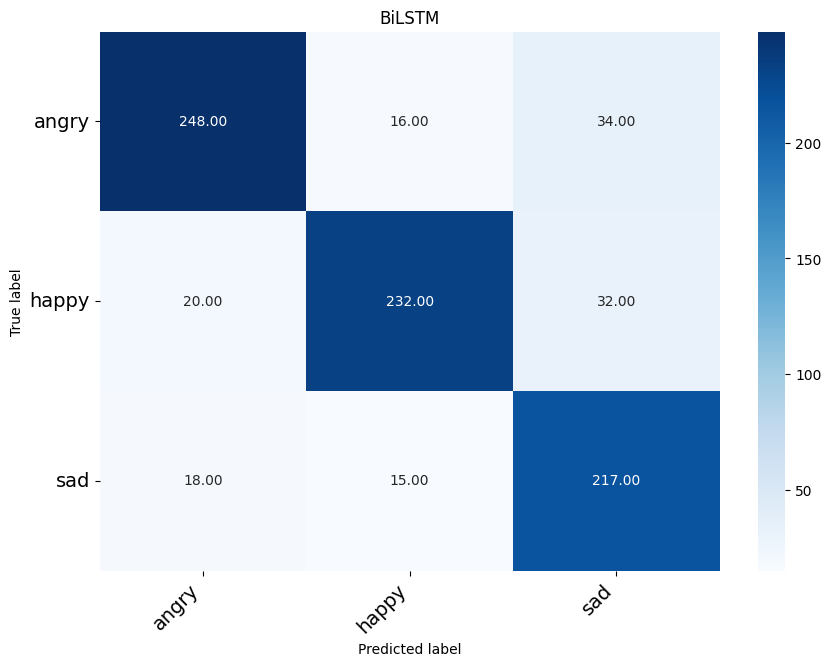

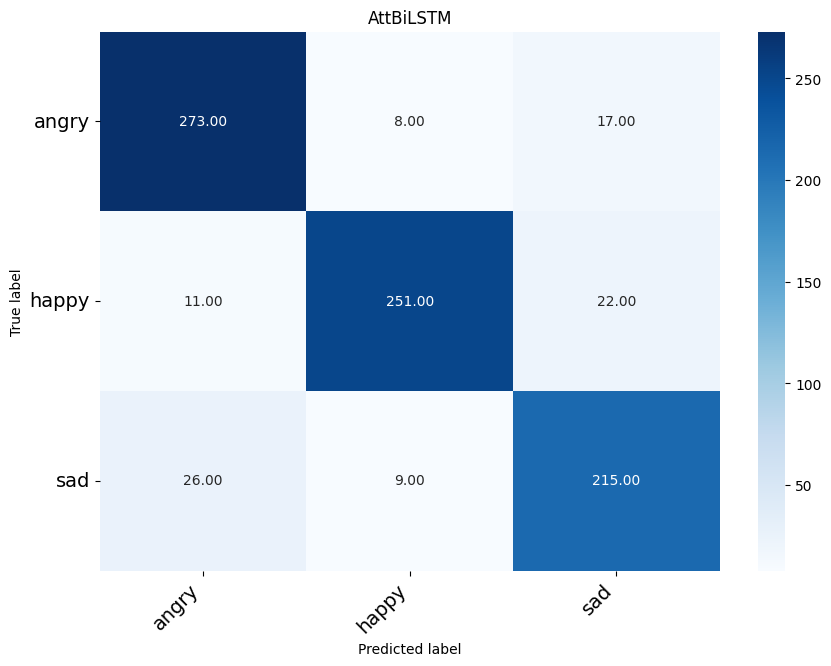

In [17]:
# plot confusion matrix for each models predictions on test set using seaborn

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    fig = plt.figure(figsize=(10, 7))
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=".2f", cmap=cmap)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    return fig

# Plot the confusion matrices
plot_confusion_matrix(y_true1, y_pred1, label_encoder.classes_, title='CNN')
plot_confusion_matrix(y_true2, y_pred2, label_encoder.classes_, title='BiLSTM')
plot_confusion_matrix(y_true3, y_pred3, label_encoder.classes_, title='AttBiLSTM')

